# ICC Profile support

In [1]:

import os
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt


Setting resource folder

In [2]:
resources_dir = os.getenv("PYNVIMGCODEC_EXAMPLES_RESOURCES_DIR", "../assets/images/")


Import nvImageCodec module and create Decoder

In [3]:
from nvidia import nvimgcodec
decoder = nvimgcodec.Decoder()

Parse Aperio SVS file to extract ICC color profile and image metadata from all sub-images

In [ ]:

img_full_path = os.path.abspath(os.path.join(resources_dir, "JP2K-33003-1.svs"))
cs = nvimgcodec.CodeStream(img_full_path)
print(f"Number of images: {cs.num_images}")

icc_profile = None
for code_stream_idx in range(cs.num_images):
    print(f"Image #{code_stream_idx}")
    scs = cs.get_sub_code_stream(code_stream_idx)
    print(f"{' ' * 5}width: {scs.width}")
    print(f"{' ' * 5}height: {scs.height}")
    
    metadata = decoder.get_metadata(scs)
    for m in metadata:
        print(f"{' ' * 5}{m}")
        if m.kind != nvimgcodec.MetadataKind.ICC_PROFILE:
            print(f"{' ' * 5}{m.buffer.decode('utf-8')}")
        else:
            print(f"{' ' * 5}{m.buffer}")
            icc_profile = m.buffer
        print()


Number of images: 6
Image #0
     width: 15374
     height: 17497
     Metadata(kind=MetadataKind.MED_APERIO format=MetadataFormat.RAW buffer_size=530)
     Aperio Image Library v10.0.50
16000x17597 [0,100 15374x17497] (256x256) J2K/YUV16 Q=70|AppMag = 40|StripeWidth = 1000|ScanScope ID = SS1283|Filename = 6797|Title = univ missouri 07.15.09|Date = 07/16/09|Time = 18:15:06|User = 93d70f65-3b32-4072-ba6a-bd6785a781be|MPP = 0.2498|Left = 39.010742|Top = 14.299895|LineCameraSkew = -0.003035|LineAreaXOffset = 0.000000|LineAreaYOffset = 0.000000|Focus Offset = -0.001000|DSR ID = homer|ImageID = 6797|OriginalWidth = 16000|Originalheight = 17597|Filtered = 3|ICC Profile = ScanScope v1

     Metadata(kind=MetadataKind.ICC_PROFILE format=MetadataFormat.RAW buffer_size=141992)
     b'\x00\x02*\xa8APPL\x02@\x00\x00scnrRGB Lab \x07\xd7\x00\n\x00\x0f\x00\x0e\x00\x1e\x00\x02acspMSFT\x00\x00\x00\x00        \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-LO

Decode sub-image #1 (lower resolution) for faster processing and comparison

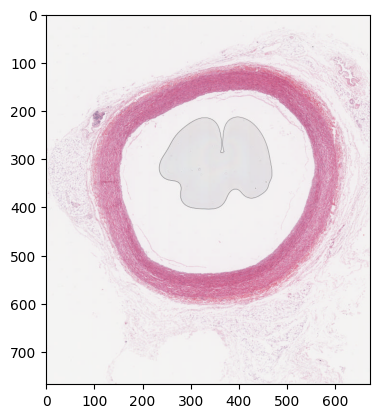

In [ ]:
scs = cs.get_sub_code_stream(1)
#scs = cs.get_sub_code_stream(1, nvimgcodec.Region(start_y=150, start_x=90, end_y=250, end_x=  200)) # uncomment to get a part of the image

nv_img = decoder.decode(scs, params=nvimgcodec.DecodeParams(allow_any_depth=True, color_spec=nvimgcodec.ColorSpec.UNCHANGED))

plt.imshow(nv_img.cpu())

Apply ICC color profile transformation using PIL's ImageCms module to convert from source color space to sRGB

In [6]:
from PIL import Image, ImageCms

from io import BytesIO

icc_stream = BytesIO(icc_profile)

src_profile = ImageCms.ImageCmsProfile(icc_stream)
dst_profile = ImageCms.createProfile("sRGB") # or load another profile
    
np_img = np.array(nv_img.cpu())
pil_img = Image.fromarray(np_img)
transform = ImageCms.buildTransform(src_profile, dst_profile,  pil_img.mode, pil_img.mode)
converted_img = ImageCms.applyTransform(pil_img, transform)



The color transformation effect may be subtle, so we calculate the pixel-wise difference to make the changes more visible

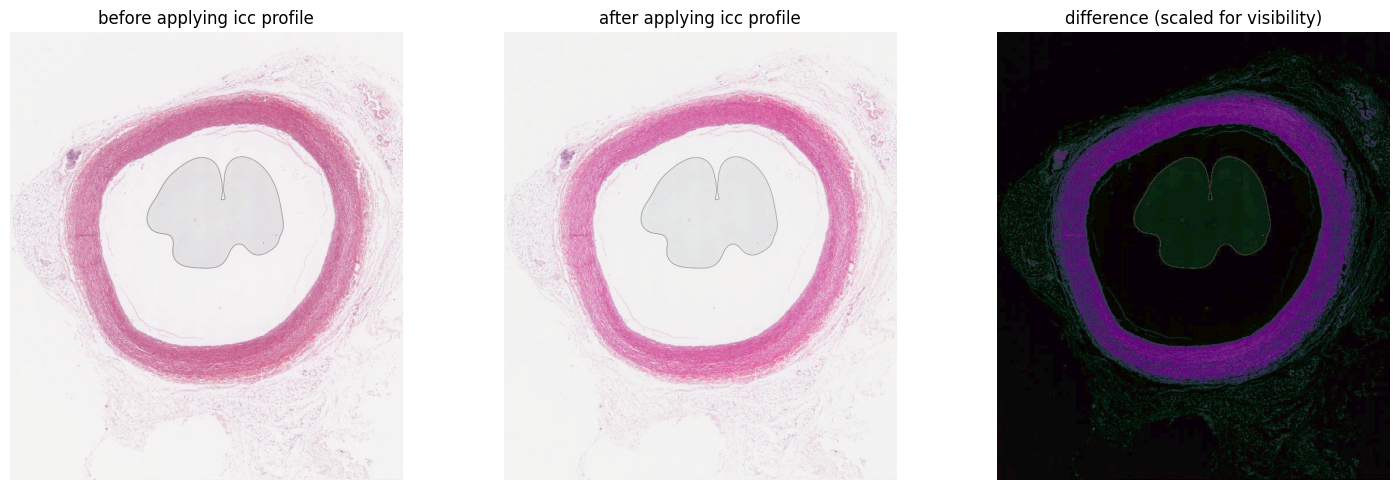

In [19]:
diff = np.asarray(pil_img).astype(np.int16) - np.asarray(converted_img).astype(np.int16)

# To make small differences more visible, we can scale the diff for display.
# We'll calculate the absolute value, clip and normalize the diff to [0, 255] and convert to uint8 for imshow.
diff_vis = np.clip(np.abs(diff) * 8, 0, 255).astype(np.uint8)  # scale factor can be adjusted

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(pil_img)
axes[0].set_title("before applying icc profile")
axes[0].axis('off')

axes[1].imshow(converted_img)
axes[1].set_title("after applying icc profile")
axes[1].axis('off')

axes[2].imshow(diff_vis)
axes[2].set_title("difference (scaled for visibility)")
axes[2].axis('off')
plt.tight_layout()
plt.show()